In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
import re
from scipy.signal import find_peaks
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [3]:
def save_area_array(area_array, out_path):
    np.save(out_path, area_array)

# Define Gaussian function
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_and_plot_gaussian(hist_data, bins, label=None, color=None, mask_range=(-4, 5)):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    mask = (bin_centers > mask_range[0]) & (bin_centers < mask_range[1])
    popt, pcov = curve_fit(gaussian, bin_centers[mask], hist_data[mask], p0=[np.max(hist_data), np.mean(bin_centers[mask]), np.std(bin_centers[mask])])
    plt.bar(bins[:-1], hist_data, width=np.diff(bins), alpha=0.5, label=label, color=color)
    plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label=f'Gaussian fit {label}')
    plt.legend()
    return popt, pcov

def analyse_field_scan(base_dir, voltage_pairs, pattern = None, s2_cuts = (0.5e-5, 1.5e-5),
                       hist_cuts = (-5, 20)):
    # Drift field scan (vary both voltages together)
    if pattern is None:
        pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
    glob_pattern = pattern + '/*.wfm'
    s2_lowcut, s2_upcut = s2_cuts
    hist_lowcut, hist_upcut = hist_cuts

    s2_areas = {}
    s2_areas_cuts = {}
    for el_v, gate_v in voltage_pairs:
        path = os.path.join(base_dir, glob_pattern.format(el_v, gate_v))
        files = sorted(glob(path))
        print(f'Integrating {len(files)} files for EL {el_v} V, Gate {gate_v} V')
        arr = extract_s2_areas(files, s2_lowcut, s2_upcut)
        s2_areas[(el_v, gate_v)] = arr
        s2_areas_cuts[(el_v, gate_v)] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)
        # out_path = os.path.join(base_dir, f'FieldScan_EL{el_v}_Gate{gate_v}', f'histogram_EL{el_v}_Gate{gate_v}.png')
        # save_histogram(s2_areas_cuts[(el_v, gate_v)], bins=150, out_path=out_path,
        #                xlabel='S2 Area (mV*us)', ylabel='Counts',
        #                title=f'EL {el_v} V, Gate {gate_v} V')
        area_out_path = os.path.join(base_dir, pattern.format(el_v, gate_v), f'area_s2_EL{el_v}_Gate{gate_v}.npy')
        save_area_array(arr, area_out_path)

    # Plot all histograms together
    plt.figure(figsize=(8, 6))
    for (el_v, gate_v) in voltage_pairs:
        label = f"$E_{{drift}}$: {round(gate_v/1.4)} V/cm, $V_{{anode}}$: {el_v} V"
        plt.hist(s2_areas_cuts[(el_v, gate_v)], bins=150, alpha=0.5, label=label)
    plt.xlabel('S2 Area (mV*us)')
    plt.ylabel('Counts')
    plt.title('Drift field scan, EL field: 1.75 kV/cm')
    plt.legend()
    return s2_areas_cuts, s2_areas
    # plt.savefig(os.path.join(base_dir, 'field_scan_all.png'))
    


# Inspect average wfm and baselines

In [ ]:
def shift_trigger_to_start(trigger_file, t):
    trig = wfm2read(trigger_file, verbose=False)
    trig_x, trig_y = trig[1], trig[0]
    trig_y = trig_y / (200 * np.max(trig_y))
    trig_x = trig_x[:int(len(trig_x)/2)]
    trig_y = trig_y[:int(len(trig_y)/2)]
    # ind_peak = trig_y.argmax()
    # t2 = trig_x - trig_x[ind_peak]

    ind_slice = np.where(trig_x > t[0])[0][0]
    slice_y = trig_y[:ind_slice]
    slice_x = np.linspace(trig_x[-1], t[-1], num=len(trig_x[:ind_slice]))
    trig_x2 = np.append(trig_x[ind_slice:], slice_x)
    trig_y2 = np.append(trig_y[ind_slice:], slice_y)
    return trig_x2, trig_y2

In [201]:
def compute_average_waveform(files):
    w = wfm2read(files[0], verbose=False)
    t, V = w[1], -w[0]

    V_avg = np.zeros_like(V)

    for f in files:
        w = wfm2read(f, verbose=False)
        t, V = w[1], -w[0]
        V_avg += V
    V_avg /= len(files)
    V_avg -= np.min(V_avg)
    return V_avg, t

In [183]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/sca_waveform.wfm'

file0 = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL2450_Gate50/RUN2_21082025_Gate50_Anode2450_P1_0000.wfm'
w = wfm2read(file0, verbose=False)
t, V = w[1], -w[0]
trig_x, trig_y = shift_trigger_to_start(trigger_file, t)

Anode voltage : 2450, Gate voltage : 50
Anode voltage : 2460, Gate voltage : 60
Anode voltage : 2470, Gate voltage : 70
Anode voltage : 2480, Gate voltage : 80
Anode voltage : 2490, Gate voltage : 90
Anode voltage : 2500, Gate voltage : 100
Anode voltage : 2550, Gate voltage : 150
Anode voltage : 2600, Gate voltage : 200
Anode voltage : 2650, Gate voltage : 250
Anode voltage : 2700, Gate voltage : 300
Anode voltage : 2750, Gate voltage : 350
Anode voltage : 2800, Gate voltage : 400
Anode voltage : 2850, Gate voltage : 450
Anode voltage : 2900, Gate voltage : 500
Anode voltage : 3000, Gate voltage : 600


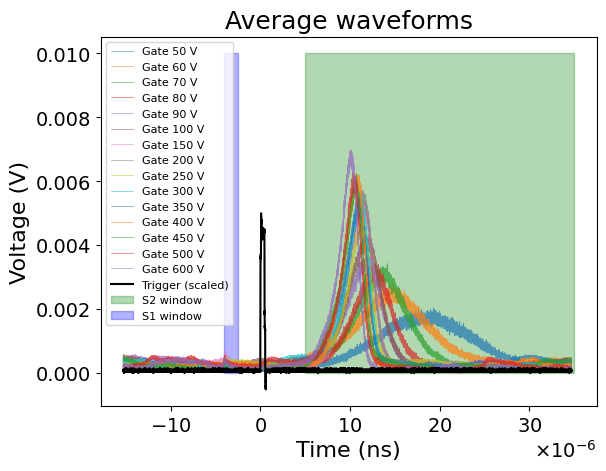

In [ ]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/'
subdirs = sorted(os.listdir(base_dir))
for subdir in subdirs[:-1]:
    try:
        gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
        anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
        print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
        files = sorted(glob(base_dir+subdir+'/*.wfm'))
        V_avg, t = compute_average_waveform(files)
        plt.plot(t, V_avg, '-', alpha=0.7, lw=0.5, label=f'Gate {gate_voltage} V')

    except AttributeError:
        continue

plt.plot(trig_x, trig_y, 'k', label='Trigger (scaled)')

s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
plt.fill_betweenx([0, 0.01], x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window')

s1_lowcut, s1_upcut = -0.4e-5, -0.25e-5
plt.fill_betweenx([0, 0.01], x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window')

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))
ax.set(xlabel='Time (ns)', ylabel='Voltage (V)', title='Average waveforms')
plt.legend(fontsize=8)

Anode voltage : 1750, Gate voltage : 350


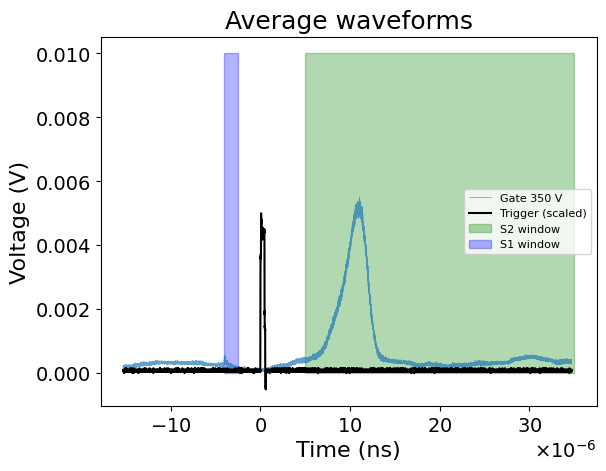

In [205]:
subdir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL2750_Gate350/*.wfm'

gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
files = sorted(glob(subdir))
V_avg, t = compute_average_waveform(files)
plt.plot(t, V_avg, '-', alpha=0.7, lw=0.5, label=f'Gate {gate_voltage} V')

    

plt.plot(trig_x, trig_y, 'k', label='Trigger (scaled)')

s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
plt.fill_betweenx([0, 0.01], x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window')

s1_lowcut, s1_upcut = -0.4e-5, -0.25e-5
plt.fill_betweenx([0, 0.01], x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window')

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))
ax.set(xlabel='Time (ns)', ylabel='Voltage (V)', title='Average waveforms')
plt.legend(fontsize=8)

[(-1e-06, 4e-06)]

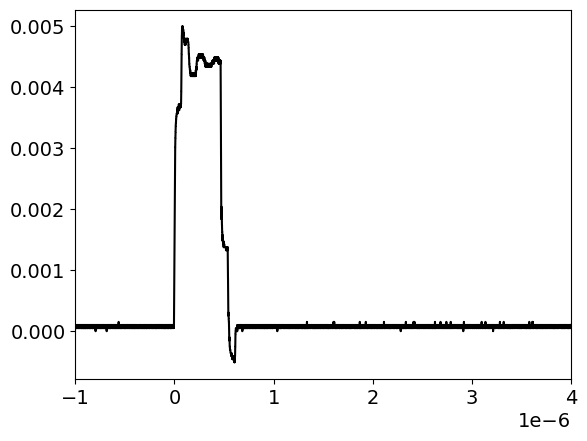

In [208]:
plt.plot(trig_x, trig_y, 'k', label='Trigger (scaled)')
plt.gca().set(xlim=(-1e-6, 4e-6))

# Baseline selection

In [236]:
def baseline_selection(file, t_window=(-1.5e-5, -1.0e-5), v_window=(-0.002, 0.002)):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    
    baseline_window = (t > t_window[0]) & (t < t_window[1]) #& (V < v_window[0]) & (V > v_window[1])
    return V[baseline_window], t[baseline_window]

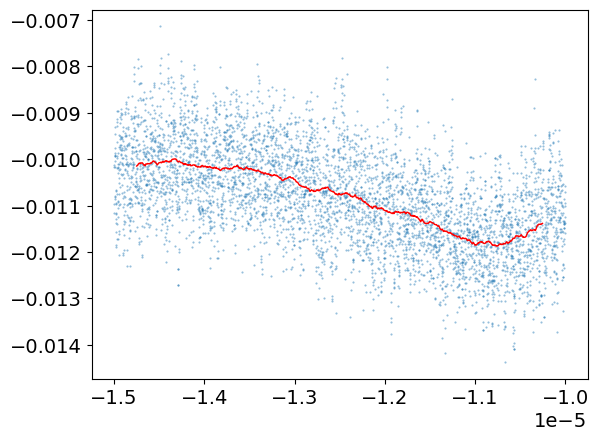

In [237]:
path05 = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL2450_Gate50/*.wfm'
files05 = sorted(glob(path05))
bs_v0, _ = baseline_selection(files05[0])
bs_values = np.zeros_like(bs_v0)
for f in files05:
    bs_v, bs_t = baseline_selection(f)
    bs_values += bs_v

window = 500
bs_values /= len(path05)
bs_smooth = moving_average(bs_values, window=window)
plt.plot(bs_t, bs_values, '.', markersize=1, alpha=0.5)
plt.plot(bs_t[int(window/2):-int(window/2)], bs_smooth[int(window/2):-int(window/2)], 'r-', lw=1, label='Baseline Moving average (window=500)')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.title('Baseline region samples for Gate 50 V')

In [222]:
len(bs_t), len(bs_values), len(bs_v)

(5000, 5000, 5000)

In [230]:
bs_smooth[:210]

array([-0.00510905, -0.00513196, -0.00515362, -0.00517476, -0.00519453,
       -0.00521489, -0.00523482, -0.00525522, -0.0052737 , -0.00529289,
       -0.00531229, -0.00533364, -0.00535551, -0.00537733, -0.00539861,
       -0.00541716, -0.00543527, -0.00545343, -0.00547085, -0.00548935,
       -0.00550503, -0.00552111, -0.00553787, -0.00555752, -0.00557688,
       -0.00559814, -0.00561814, -0.00563931, -0.00566074, -0.00568439,
       -0.00570779, -0.00573137, -0.00575327, -0.00577419, -0.00579442,
       -0.0058147 , -0.00583318, -0.00585279, -0.00587321, -0.00589567,
       -0.00591649, -0.00593721, -0.00595456, -0.00597129, -0.00598728,
       -0.00600472, -0.00602144, -0.00603962, -0.00605802, -0.00607926,
       -0.00610014, -0.0061221 , -0.00614386, -0.00616737, -0.006189  ,
       -0.00621189, -0.00623208, -0.00625395, -0.00627611, -0.00630023,
       -0.00632244, -0.00634667, -0.00636865, -0.00639005, -0.00641042,
       -0.00643098, -0.0064515 , -0.00647216, -0.00649174, -0.00